In [1]:
import sympy as sym
import numpy as np
from scipy.interpolate import *
import numpy.polynomial.legendre as leg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2D FEM SOLVER : ALLEN-CAHN EQUATION

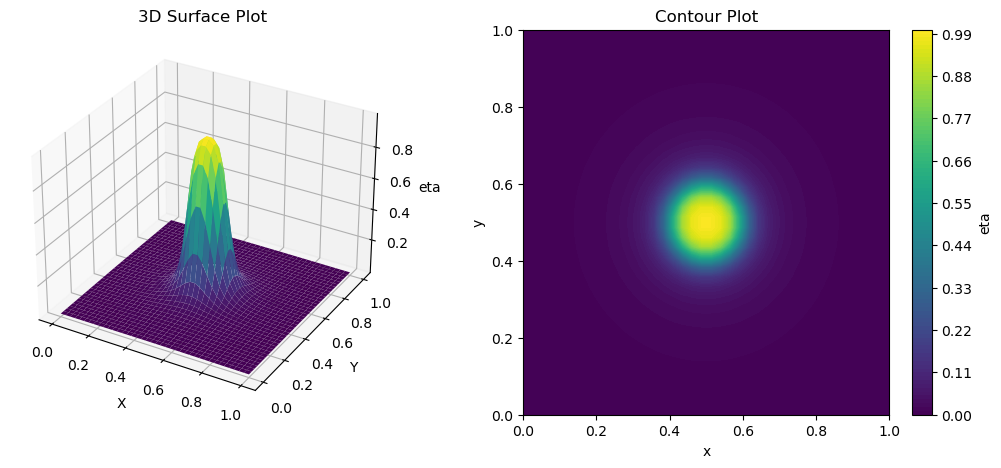

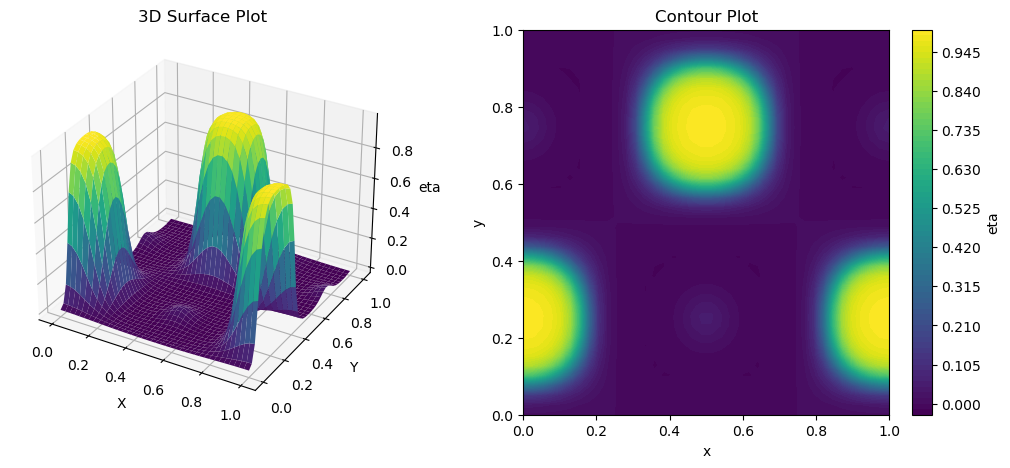

In [2]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy') #Double well Potential

def one_dim_M_K(x, ndofs,degree):
    
    basis = [PPoly.from_spline(splrep(x, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
    dbasis = [basis[i].derivative(1) for i in range(len(basis))]
    
    m = len(basis)
    intervals = np.unique(basis[0].x)
    
    qp, w = leg.leggauss(degree)
    qp += 1.
    qp /= 2.
    w /= 2.           
    
    h = np.diff(intervals)
    Q = np.array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
    W = np.array([w * h[i] for i in range(len(h))]).reshape((-1,))

    Bq = np.array([basis[i](Q) for i in range(m)]).T
    dBq = np.array([dbasis[i](Q) for i in range(m)]).T

    M = np.array([[np.dot(Bq[:, i] * W, Bq[:, j]) for j in range(m)] for i in range(m)])
    K = np.array([[np.dot(dBq[:, i] * W, dBq[:, j]) for j in range(m)] for i in range(m)])
    
    return M,K

def two_dim_tensor_M_K(M,K,n):
    
    assert M.shape[0] == K.shape[0], f"Shape Mismatch between M anb K"

    M_2d = np.zeros((n * n, n * n))
    K_2d = np.zeros((n * n, n * n))

    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    M_2d[i * n + j, k * n + l] = M[i, k]*M[j,l]
                    K_2d[i * n + j, k * n + l] = K[i, k]*M[j,l] + M[i,k]*K[j,l]
                    
    return M_2d, K_2d

def solver(func0,eps,dt,ndofs,degree):
    
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    n_steps = int(1/dt) + 1
    
    M,K = one_dim_M_K(x, ndofs, degree)
    
    n = M.shape[0]
    
    M_2d, K_2d = two_dim_tensor_M_K(M,K,n)
    
    eta_2d = np.zeros((n_steps, n * n))
    eta_2d[0] = func0(x[:, np.newaxis], y[np.newaxis, :]).flatten()

    b_2d = M_2d.dot(eta_2d[0] - dt * F(eta_2d[0].reshape((n, n))).flatten())

    for i in range(1, n_steps):
        A_2d = M_2d + dt * eps**2 * K_2d
        eta_2d[i] = np.linalg.solve(A_2d, b_2d)
        b_2d = M_2d.dot(eta_2d[i] - dt * F(eta_2d[i].reshape((n, n))).flatten())
    
    return eta_2d,n


def plot_2d(eta_2d, n, dt, ndofs):
    
    x = np.linspace(0, 1, ndofs)
    y = np.linspace(0, 1, ndofs)
    n_steps = int(1/dt) + 1
    
    X, Y = np.meshgrid(x, y)
    
    # 3D surface plot
    eta_2d_grid = eta_2d.reshape((n_steps, n, n))
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X, Y, eta_2d_grid[-1], cmap='viridis',
                   linewidth=0.5, antialiased=True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('eta')
    ax.set_title('3D Surface Plot')

    # Contour plot
    eta_2d_contour = eta_2d[-1].reshape((n, n))
    fig.add_subplot(122)
    plt.contourf(X, Y, eta_2d_contour, levels=100, cmap='viridis')
    plt.colorbar(label='eta')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Contour Plot')
    plt.show()

if __name__ == '__main__':
    
    eps = 0.01
    dt = 0.1
    ndofs = 40
    degree = 2
    
    funcs = [
        
        lambda x, y: 1 / (1 + 100 * ((x - 0.5) ** 2 + (y - 0.5) ** 2)),
        lambda x, y: np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
    ]
    
    for func0 in funcs:
        eta_2d, n = solver(func0, eps, dt, ndofs, degree)
        plot_2d(eta_2d, n, dt, ndofs)
    

## ROUGH WORK

1D M & K Shape:  (20, 20) (20, 20)
2D M & K Shape:  (400, 400) (400, 400)
2D eta Shape:  (11, 400)


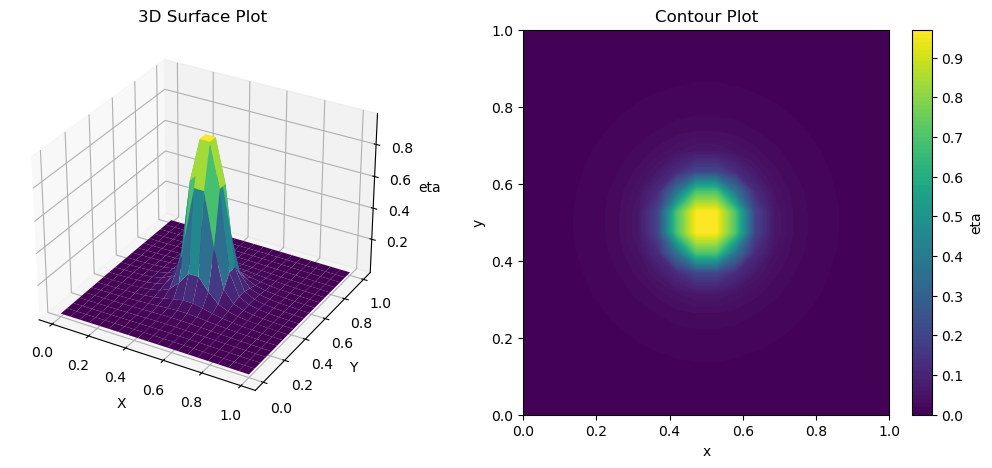

In [3]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy') #Double well Potential

func0 = lambda x,y: 1/(1+100*((x-.5)**2+(y-.5)**2))

ndofs = 20
degree = 2
eps = 0.01
dt = 0.1
n_steps = int(1/dt) + 1

x = np.linspace(0, 1, ndofs)
y = np.linspace(0, 1, ndofs)

basis = [PPoly.from_spline(splrep(x, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
dbasis = [basis[i].derivative(1) for i in range(len(basis))]

m = len(basis)

intervals = np.unique(basis[0].x)

qp, w = leg.leggauss(degree)
qp += 1.
qp /= 2.
w /= 2.          
    
h = np.diff(intervals)
Q = np.array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
W = np.array([w * h[i] for i in range(len(h))]).reshape((-1,))

Bq = np.array([basis[i](Q) for i in range(m)]).T
dBq = np.array([dbasis[i](Q) for i in range(m)]).T

M = np.array([[np.dot(Bq[:, i] * W, Bq[:, j]) for j in range(m)] for i in range(m)])
K = np.array([[np.dot(dBq[:, i] * W, dBq[:, j]) for j in range(m)] for i in range(m)])

print("1D M & K Shape: ",M.shape, K.shape)

# Using tensor product structure for 2D from 1D assemble M
assert K.shape[0] == M.shape[0] 

n = M.shape[0]

M_2d = np.zeros((n * n, n * n))
K_2d = np.zeros((n * n, n * n))

for i in range(n):
    for j in range(n):
        for k in range(n):
            for l in range(n):
                M_2d[i * n + j, k * n + l] = M[i, k]*M[j,l]
                K_2d[i * n + j, k * n + l] = K[i, k]*M[j,l] + M[i,k]*K[j,l]
                
print("2D M & K Shape: ",M_2d.shape, K_2d.shape)

eta_2d = np.zeros((n_steps, n * n))
eta_2d[0] = func0(x[:, np.newaxis], y[np.newaxis, :]).flatten()

b_2d = M_2d.dot(eta_2d[0] - dt * F(eta_2d[0].reshape((n, n))).flatten())

for i in range(1, n_steps):
    A_2d = M_2d + dt * eps**2 * K_2d
    eta_2d[i] = np.linalg.solve(A_2d, b_2d)
    b_2d = M_2d.dot(eta_2d[i] - dt * F(eta_2d[i].reshape((n, n))).flatten())

print("2D eta Shape: ",eta_2d.shape)    

#PLOT

X, Y = np.meshgrid(x, y)

# 3D surface plot
eta_2d_grid = eta_2d.reshape((n_steps, n, n))
fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, eta_2d_grid[-1], cmap='viridis',
               linewidth=0.5, antialiased=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('eta')
ax.set_title('3D Surface Plot')

# Contour plot
eta_2d_contour = eta_2d[-1].reshape((n, n))
fig.add_subplot(122)
plt.contourf(X, Y, eta_2d_contour, levels=100, cmap='viridis')
plt.colorbar(label='eta')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot')
plt.show()